In [25]:
SKIP_TRAINING = False  # Set to True to skip the training loop

import warnings

from pathlib import Path
import numpy as np
import torch
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import cv2

from src.degradations import generate_degraded_dataset_auto
from src.losses.combined_loss import CombinedLoss
from src.models.denoising_autoencoder import DenoisingAutoencoder
from src.training import get_dataloaders, run_training
from src.utils import (
    load_checkpoint,
    plot_image_comparison,
    plot_inference_results,
    plot_training_curves,
    print_training_summary,
    setup_or_resume_experiment,
    resume_training,
    download_div2k_dataset,
)
from src.evaluation import ImageRestorationEvaluator

warnings.filterwarnings("ignore")

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(
        f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB"
    )

PyTorch version: 2.9.1+cu130
CUDA available: True
CUDA device: NVIDIA GeForce GTX 1650 Ti
CUDA memory: 4.29 GB


## Experiment Configuration

In [26]:
# Training configuration
config = {
    # Resume Training
    "resume_from_checkpoint": False,
    "resume_experiment": "latest", 
    # Training
    "batch_size": 16,
    "num_epochs": 20,  # Reduced training time
    "learning_rate": 1e-4,
    "weight_decay": 1e-5,
    # Data
    "patch_size": 256,  
    "patches_per_image": 16,  # Fewer patches per epoch
    "num_workers": 4,  # Reduced CPU overhead
    # Model
    "model_features": 128,  # Lighter model
    # Loss
    "loss_alpha": 0.84,
    "loss_beta": 0.16,
    # Degradation - Gaussian Noise
    "degradation_type": "gaussian_noise",
    "noise_sigma": 50.0,
    # Optimization
    "scheduler": "cosine",
    "warmup_epochs": 2,  # Reduced for fewer total epochs
    "min_lr": 1e-6,
    # Early stopping
    "patience": 5,
    # Checkpoints
    "save_every": 10,  # Save less frequently
    "val_every": 5,  # Validate less frequently
    # Mixed Precision
    "use_amp": True,  # Keep enabled for faster training
    # Device
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "seed": 42,
}

# Set seed for reproducibility
torch.manual_seed(config["seed"])
np.random.seed(config["seed"])
if torch.cuda.is_available():
    torch.cuda.manual_seed(config["seed"])
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

print("\n📋 Configuration:")
for key, value in config.items():
    print(f"   {key}: {value}")


📋 Configuration:
   resume_from_checkpoint: False
   resume_experiment: latest
   batch_size: 16
   num_epochs: 20
   learning_rate: 0.0001
   weight_decay: 1e-05
   patch_size: 256
   patches_per_image: 16
   num_workers: 4
   model_features: 128
   loss_alpha: 0.84
   loss_beta: 0.16
   degradation_type: gaussian_noise
   noise_sigma: 50.0
   scheduler: cosine
   warmup_epochs: 2
   min_lr: 1e-06
   patience: 5
   save_every: 10
   val_every: 5
   use_amp: True
   device: cuda
   seed: 42


## Output Directories

In [27]:
exp_dir, checkpoints_dir, samples_dir, logs_dir = setup_or_resume_experiment(
    model_name="denoising_autoencoder",
    degradation="gaussian",
    config=config,
    resume_from_checkpoint=config["resume_from_checkpoint"],
    resume_experiment=config["resume_experiment"],
    custom_name="autoencoder_gaussian",
)


📁 Experiment: 20260106_234516_autoencoder_gaussian


## Tensor Board

In [28]:
# TensorBoard writer
writer = SummaryWriter(log_dir=logs_dir)

print(f"\n📊 TensorBoard logs: {logs_dir}")
print(f"   Run: tensorboard --logdir {logs_dir.absolute()}")


📊 TensorBoard logs: c:\uni\Image-Enhancement\experiments\denoising_autoencoder\gaussian\20260106_234516_autoencoder_gaussian\logs
   Run: tensorboard --logdir c:\uni\Image-Enhancement\experiments\denoising_autoencoder\gaussian\20260106_234516_autoencoder_gaussian\logs


## Generate Degraded Dataset

In [29]:
# Generate degraded datasets (auto-checks if already exists)
print("=" * 80)
print("🎨 Generating/Loading Degraded Datasets")
print("=" * 80)
print(f"Degradation: Gaussian Noise (σ={config['noise_sigma']})")
print(f"Auto-path: data/degraded/gaussian/sigma_{int(config['noise_sigma'])}/\n")

# Training dataset
train_degraded_dir, train_clean_dir = generate_degraded_dataset_auto(
    dataset_split="DIV2K_train_HR",
    degradation_type="gaussian_noise",
    noise_sigma=config["noise_sigma"],
    seed=None,
)

# Validation dataset
val_degraded_dir, val_clean_dir = generate_degraded_dataset_auto(
    dataset_split="DIV2K_valid_HR",
    degradation_type="gaussian_noise",
    noise_sigma=config["noise_sigma"],
    seed=None,
)

# Add paths to config for dataloaders
config["train_degraded_dir"] = str(train_degraded_dir)
config["train_clean_dir"] = str(train_clean_dir)
config["val_degraded_dir"] = str(val_degraded_dir)
config["val_clean_dir"] = str(val_clean_dir)

print("=" * 80)
print("✅ Datasets ready!")
print("=" * 80)

🎨 Generating/Loading Degraded Datasets
Degradation: Gaussian Noise (σ=50.0)
Auto-path: data/degraded/gaussian/sigma_50/

🎨 Generating degraded dataset: c:\uni\Image-Enhancement\data\degraded\gaussian\sigma_50\DIV2K_train_HR
🔍 Found 800 images in c:\uni\Image-Enhancement\data\raw\DIV2K_train_HR
📦 Degradation: Gaussian Noise (σ=50.0)
💾 Saving to: c:\uni\Image-Enhancement\data\degraded\gaussian\sigma_50\DIV2K_train_HR


Processing images:   0%|          | 0/800 [00:00<?, ?it/s]

✅ Done! Processed 800 images
🎨 Generating degraded dataset: c:\uni\Image-Enhancement\data\degraded\gaussian\sigma_50\DIV2K_valid_HR
🔍 Found 100 images in c:\uni\Image-Enhancement\data\raw\DIV2K_valid_HR
📦 Degradation: Gaussian Noise (σ=50.0)
💾 Saving to: c:\uni\Image-Enhancement\data\degraded\gaussian\sigma_50\DIV2K_valid_HR


Processing images:   0%|          | 0/100 [00:00<?, ?it/s]

✅ Done! Processed 100 images
✅ Datasets ready!


## Create Dataloaders

In [30]:
# Create dataloaders
train_loader, val_loader = get_dataloaders(
    train_degraded_dir=config["train_degraded_dir"],
    train_clean_dir=config["train_clean_dir"],
    val_degraded_dir=config["val_degraded_dir"],
    val_clean_dir=config["val_clean_dir"],
    batch_size=config["batch_size"],
    patch_size=config["patch_size"],
    patches_per_image=config["patches_per_image"],
    num_workers=config["num_workers"],
)

print(f"\n   Batches per epoch: {len(train_loader)} train, {len(val_loader)} val")

Loaded 800 valid images for train set
Loaded 100 valid images for val set
📊 Dataset Summary:
   Train: 12800 patches from 800 images
   Val:   1600 patches from 100 images
   Batch size: 16
   Patch size: 256x256

   Batches per epoch: 800 train, 100 val


## Visualize Data

Batch shapes:
   Degraded: torch.Size([16, 3, 256, 256])
   Clean: torch.Size([16, 3, 256, 256])
   Range: [-1.000, 1.000]


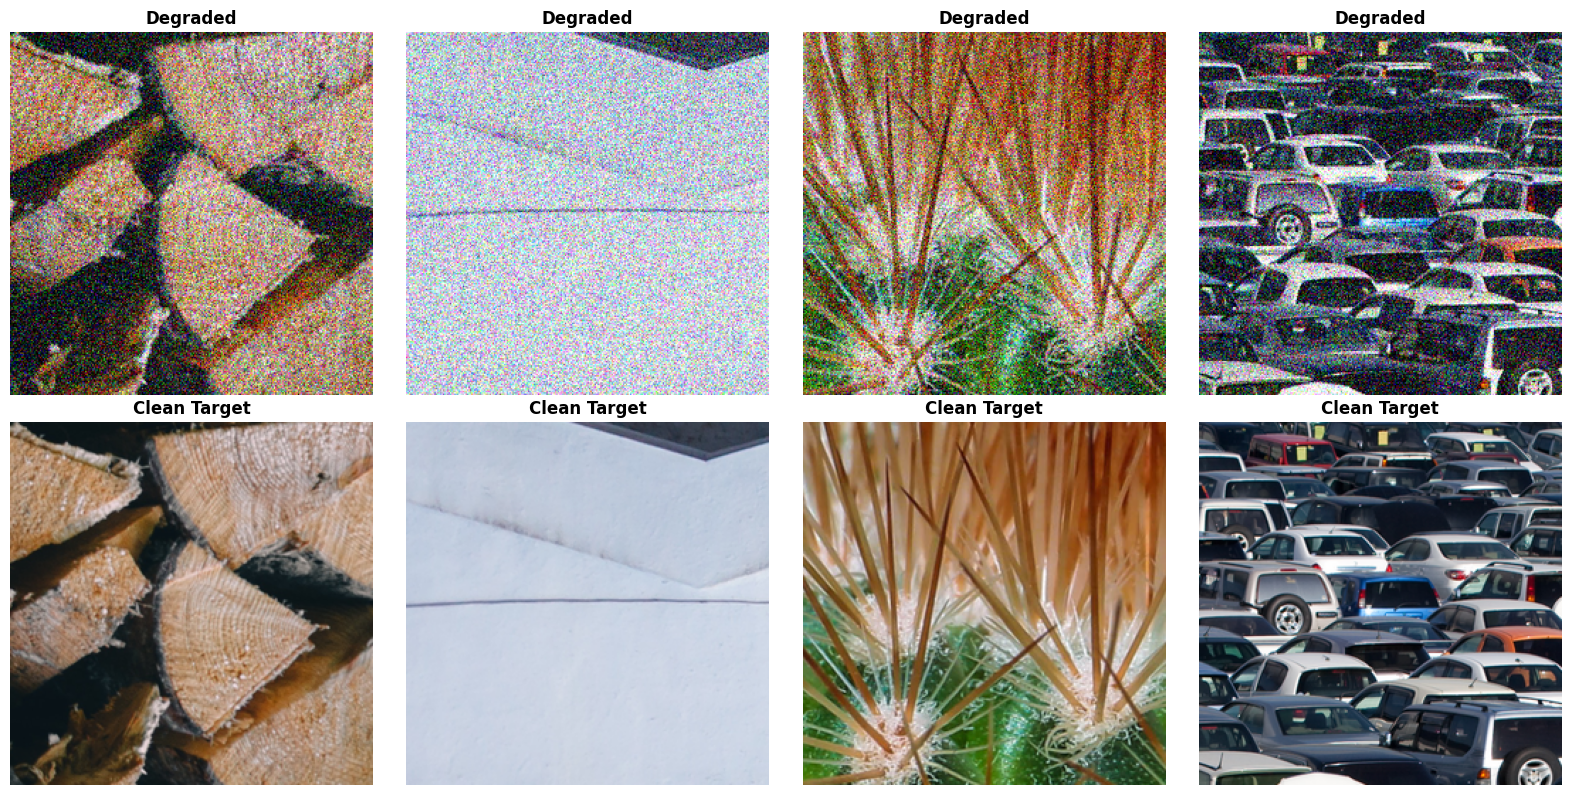


✅ Sample batch saved to c:\uni\Image-Enhancement\experiments\denoising_autoencoder\gaussian\20260106_234516_autoencoder_gaussian\samples\training_samples.png


In [31]:
# Visualize a batch
degraded_batch, clean_batch = next(iter(train_loader))

print("Batch shapes:")
print(f"   Degraded: {degraded_batch.shape}")
print(f"   Clean: {clean_batch.shape}")
print(f"   Range: [{degraded_batch.min():.3f}, {degraded_batch.max():.3f}]")

# Show sample using utility function
plot_image_comparison(
    degraded_batch=degraded_batch,
    clean_batch=clean_batch,
    n_samples=4,
    save_path=samples_dir / "training_samples.png",
)

print(f"\n✅ Sample batch saved to {samples_dir / 'training_samples.png'}")

# Initialize Model, Loss and Optimizer

In [32]:
# Create model
model = DenoisingAutoencoder(features=config["model_features"]).to(config["device"])

print("\n🤖 Model: DenoisingAutoencoder")
print(f"   Parameters: {sum(p.numel() for p in model.parameters())}")
print(f"   Device: {config['device']}")

# Loss function
criterion = CombinedLoss(alpha=config["loss_alpha"], beta=config["loss_beta"]).to(
    config["device"]
)

print(f"\n📉 Loss: L1 + SSIM (α={config['loss_alpha']}, β={config['loss_beta']})")

# Optimizer
optimizer = optim.AdamW(
    model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"]
)

print("\n⚙️  Optimizer: AdamW")
print(f"   Learning rate: {config['learning_rate']}")
print(f"   Weight decay: {config['weight_decay']}")

# Learning rate scheduler
scheduler = None
if config["scheduler"] == "cosine":
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=config["num_epochs"] - config["warmup_epochs"],
        eta_min=config["min_lr"],
    )
    print("\n📅 Scheduler: CosineAnnealingLR")
    print(f"   Warmup epochs: {config['warmup_epochs']}")
    print(f"   Min LR: {config['min_lr']}")
else:
    print("\n📅 No scheduler configured")

# Resume from checkpoint if enabled
start_epoch = 0
initial_best_loss = float("inf")
initial_best_epoch = 0
initial_history = None

if config["resume_from_checkpoint"]:
    (
        checkpoint_info,
        start_epoch,
        initial_history,
        exp_dir,
        initial_best_epoch,
    ) = resume_training(
        model=model,
        optimizer=optimizer,
        scheduler=scheduler,
        experiment_path=config["resume_experiment"],
        model_name="unet",
        degradation="gaussian",
        device=config["device"],
    )
    initial_best_loss = (
        checkpoint_info["metrics"].get("val", {}).get("loss", float("inf"))
    )
else:
    print("\n🆕 Starting fresh training (resume_from_checkpoint=False)")


🤖 Model: DenoisingAutoencoder
   Parameters: 186371
   Device: cuda

📉 Loss: L1 + SSIM (α=0.84, β=0.16)

⚙️  Optimizer: AdamW
   Learning rate: 0.0001
   Weight decay: 1e-05

📅 Scheduler: CosineAnnealingLR
   Warmup epochs: 2
   Min LR: 1e-06

🆕 Starting fresh training (resume_from_checkpoint=False)


## Training Loop

In [ ]:
if not SKIP_TRAINING:
    # Run training
    history, best_info = run_training(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        device=config["device"],
        num_epochs=config["num_epochs"],
        checkpoints_dir=checkpoints_dir,
        writer=writer,
        warmup_epochs=config["warmup_epochs"],
        learning_rate=config["learning_rate"],
        patience=config["patience"],
        save_every=config["save_every"],
        val_every=config["val_every"],
        start_epoch=start_epoch,
        initial_best_loss=initial_best_loss,
        initial_best_epoch=initial_best_epoch,  # Pass best epoch from checkpoint
        initial_history=initial_history,  # Continue from previous history
        use_amp=config["use_amp"],  # Enable mixed precision training
        config=config,
    )

    # Extract best model info
    best_epoch = best_info["best_epoch"]
    best_val_loss = best_info["best_val_loss"]

    print(f"✅ Training history saved to {exp_dir / 'history.json'}")
else:
    # Skip training: Load existing history and best model info
    print("\n" + "=" * 80)
    print("⏭️  SKIP_TRAINING = True: Loading existing results")
    print("=" * 80 + "\n")

    from src.utils.experiment import load_training_history

    try:
        history = load_training_history(exp_dir)
        print(f"✅ Loaded history from {exp_dir / 'history.json'}")
        print(f"   Total epochs: {len(history['train_loss'])}")

        # Find best epoch from history
        if history.get("val_loss"):
            # Filter out None values (epochs without validation)
            val_losses = [
                (i, loss)
                for i, loss in enumerate(history["val_loss"])
                if loss is not None
            ]
            if val_losses:
                best_epoch, best_val_loss = min(val_losses, key=lambda x: x[1])
                best_epoch += 1  # Convert to 1-indexed
                print(f"   Best epoch: {best_epoch} (val_loss: {best_val_loss:.4f})")
            else:
                best_val_loss = float("inf")
                best_epoch = 0
                print("   No validation history found")
        else:
            best_val_loss = float("inf")
            best_epoch = 0
            print("   No validation history found")

        # Create best_info dict for consistency
        best_info = {"best_epoch": best_epoch, "best_val_loss": best_val_loss}

    except FileNotFoundError:
        print(f"⚠️  No history found in {exp_dir}")
        print("   Creating empty history (train first to generate data)")
        history = {
            "train_loss": [],
            "train_l1": [],
            "train_ssim": [],
            "val_loss": [],
            "val_l1": [],
            "val_ssim": [],
            "lr": [],
        }
        best_epoch = 0
        best_val_loss = float("inf")
        best_info = {"best_epoch": best_epoch, "best_val_loss": best_val_loss}

    print("=" * 80 + "\n")

⚡ Mixed Precision Training: ENABLED (fp16)

🚀 Starting Training
   Epochs: 1 to 20



📊 Overall Progress:   0%|          | 0/20 epochs [00:00<?, ?it/s]

Epoch 1 [Train]:   0%|          | 0/800 [00:02<?] 


Epoch 1/20
  Train - Loss: 0.4668 | L1: 0.4375 | SSIM: 0.379
  LR: 0.000050 | Time: 607.2s | VRAM: 344MB
--------------------------------------------------------------------------------


Epoch 2 [Train]:   0%|          | 0/800 [00:00<?] 


Epoch 2/20
  Train - Loss: 0.3322 | L1: 0.3016 | SSIM: 0.508
  LR: 0.000100 | Time: 610.0s | VRAM: 344MB
--------------------------------------------------------------------------------


Epoch 3 [Train]:   0%|          | 0/800 [00:00<?] 

## Plot Training Curves

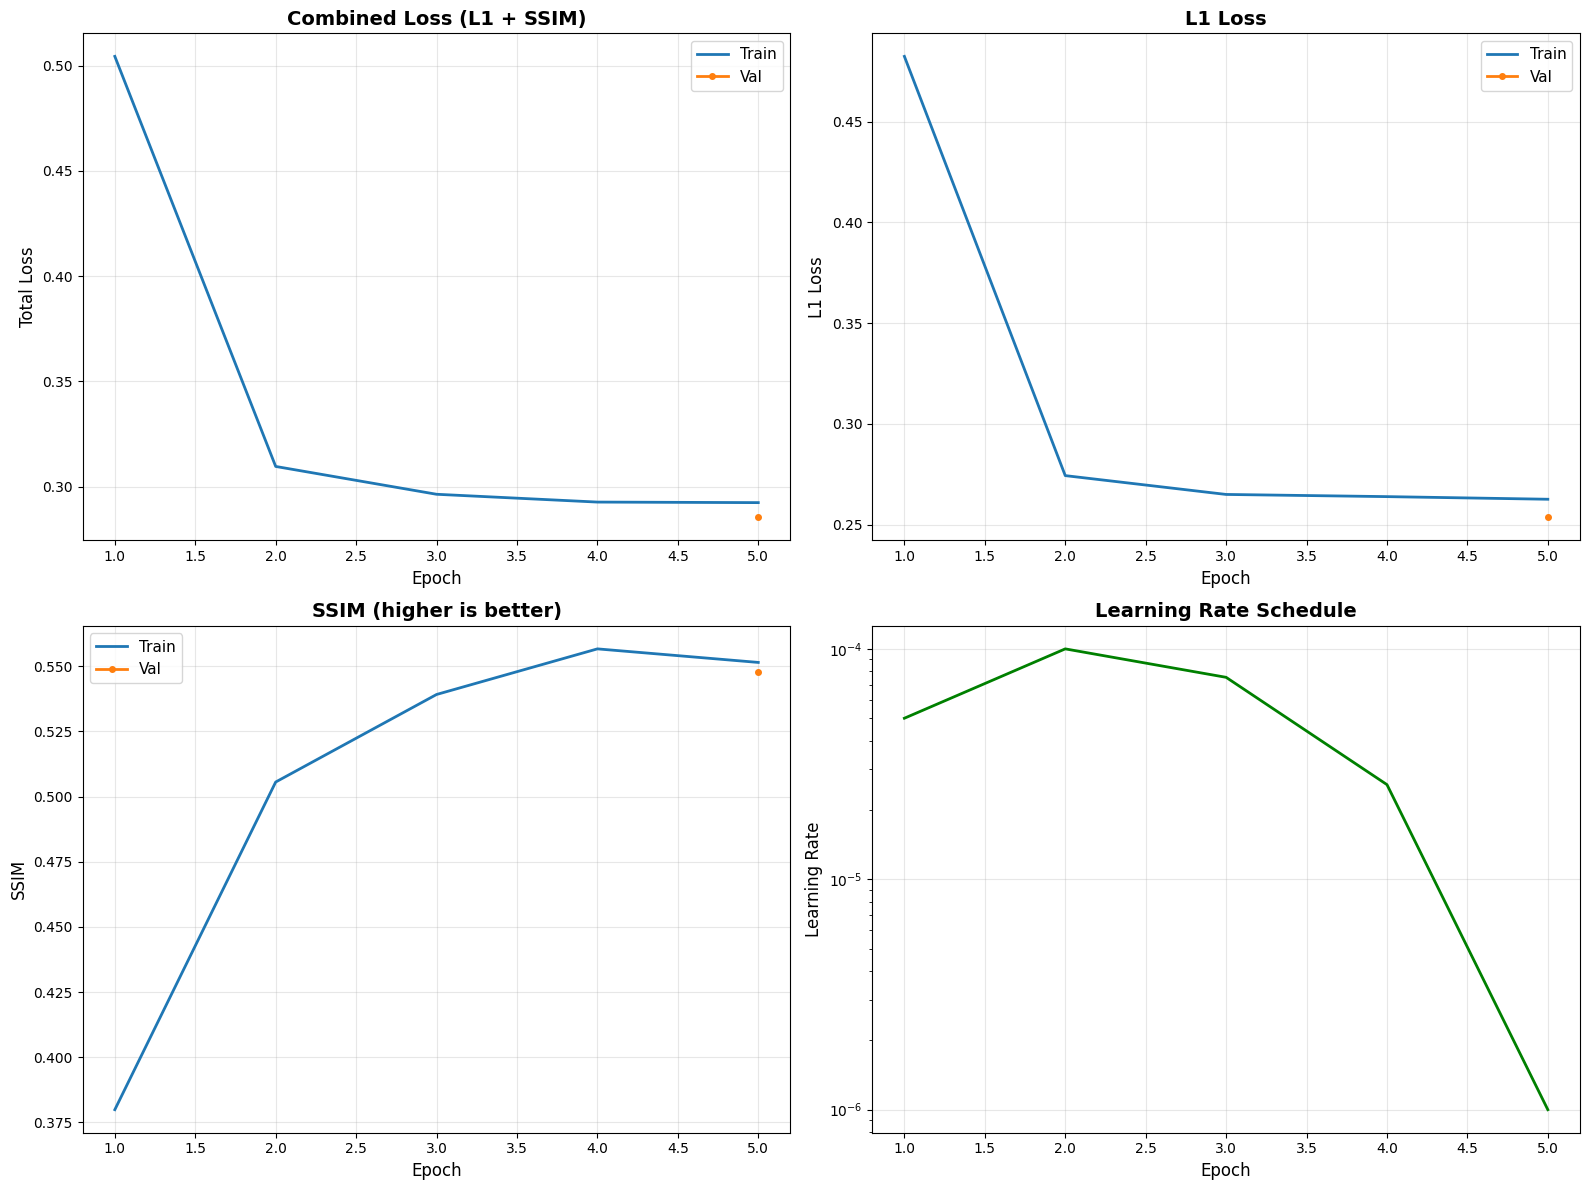


✅ Training curves saved to c:\uni\Image-Enhancement\experiments\denoising_autoencoder\gaussian\20260106_201033_autoencoder_gaussian\training_curves.png


In [ ]:
# Plot training curves using utility function
plot_training_curves(history=history, save_path=exp_dir / "training_curves.png")

print(f"\n✅ Training curves saved to {exp_dir / 'training_curves.png'}")

## Test Inference on Validation Samples


✅ Loaded best model from epoch 5


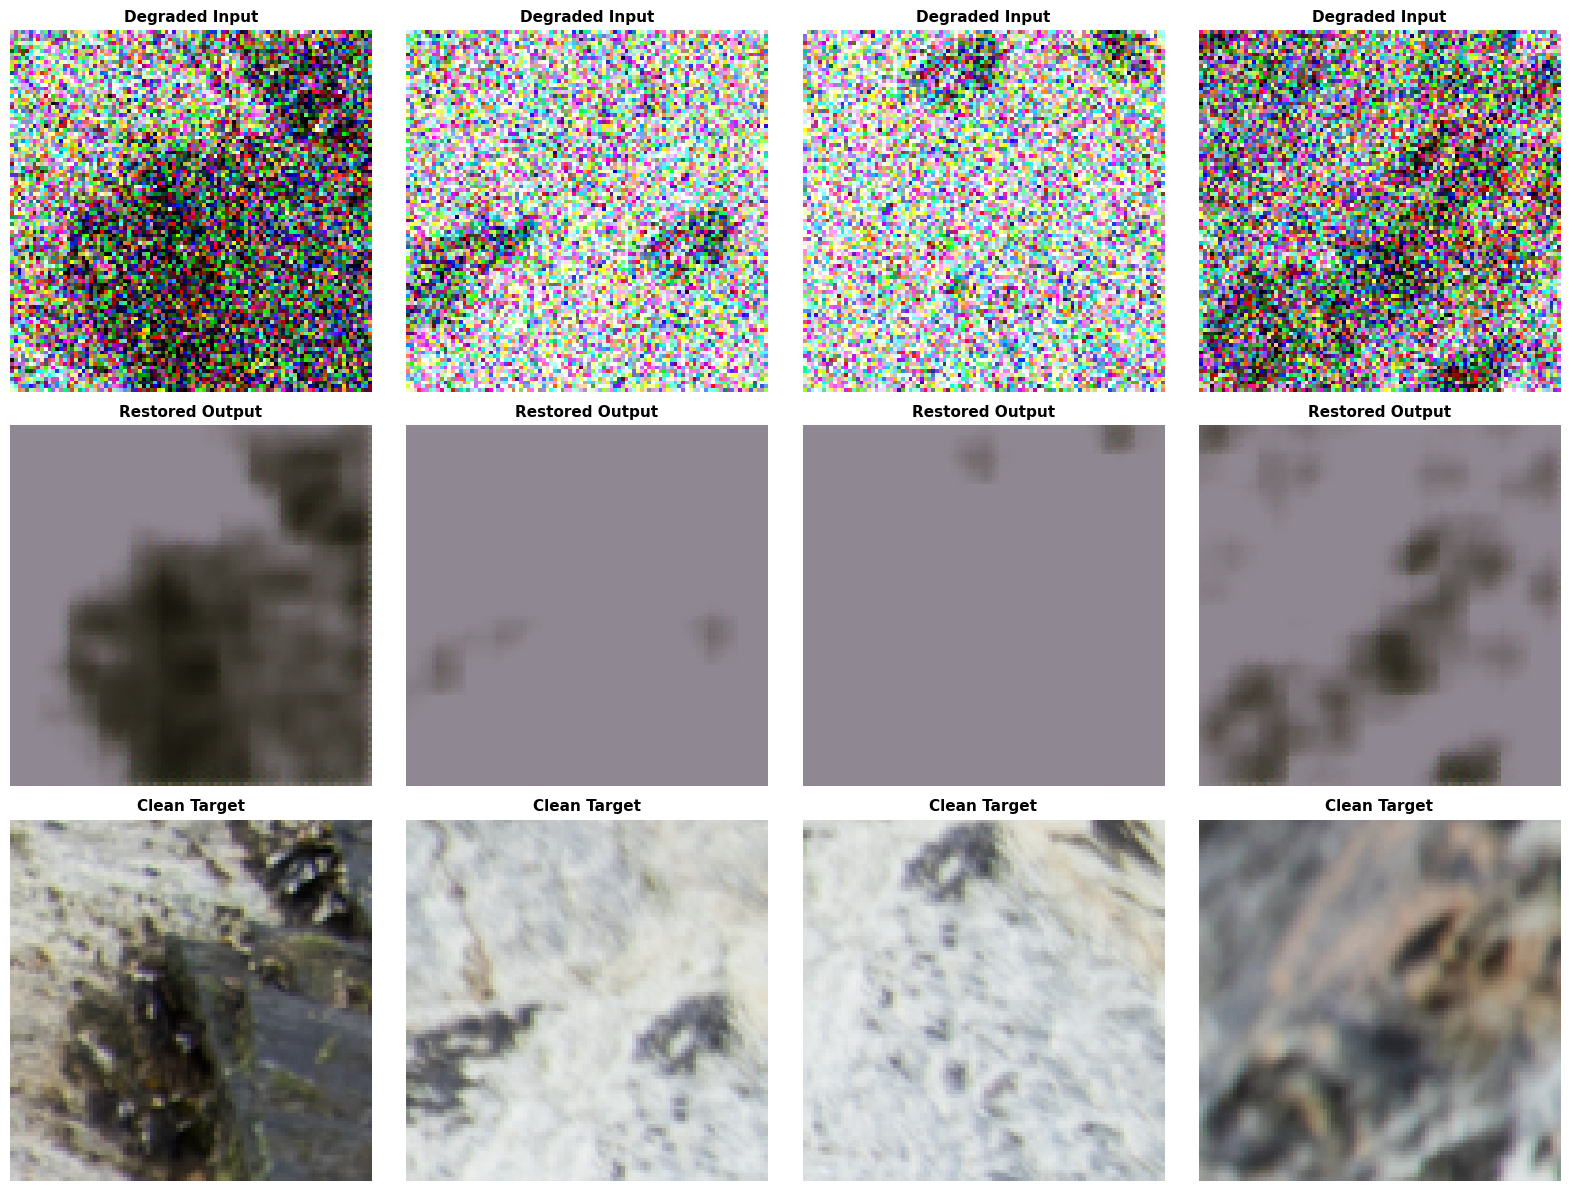


✅ Inference results saved to c:\uni\Image-Enhancement\experiments\denoising_autoencoder\gaussian\20260106_201033_autoencoder_gaussian\samples\inference_results.png


In [ ]:
# Load best model
checkpoint_info = load_checkpoint(
    checkpoints_dir / "best_model.pth", model=model, device=config["device"]
)

print(f"✅ Loaded best model from epoch {checkpoint_info['epoch']}")

# Get validation batch
degraded_batch, clean_batch = next(iter(val_loader))
degraded_batch = degraded_batch.to(config["device"])
clean_batch = clean_batch.to(config["device"])

# Inference
with torch.no_grad():
    restored_batch = model(degraded_batch)

# Visualize results using utility function
plot_inference_results(
    degraded_batch=degraded_batch,
    restored_batch=restored_batch,
    clean_batch=clean_batch,
    n_samples=4,
    save_path=samples_dir / "inference_results.png",
)

print(f"\n✅ Inference results saved to {samples_dir / 'inference_results.png'}")

## Summary

In [ ]:
# Print training summary
print_training_summary(
    history=history,
    best_epoch=best_epoch,
    best_val_loss=best_val_loss,
    exp_dir=exp_dir,
    checkpoints_dir=checkpoints_dir,
    samples_dir=samples_dir,
    logs_dir=logs_dir,
)


📊 TRAINING SUMMARY

Experiment directory: c:\uni\Image-Enhancement\experiments\denoising_autoencoder\gaussian\20260106_201033_autoencoder_gaussian

Validation points saved: 5
Best epoch: 5

Best Validation Metrics:
  Loss: 0.2854
  L1: 0.2537
  SSIM: 0.5480

Final Training Metrics:
  Loss: 0.2924
  L1: 0.2626
  SSIM: 0.5515

Performance Statistics:
  Total training time: 0.19h (668s)
  Total epochs trained: 5
  Avg epoch time: 668.2s
  Avg inference time: 70.4s
  Peak memory: 0MB

Saved files:
  Best model: c:\uni\Image-Enhancement\experiments\denoising_autoencoder\gaussian\20260106_201033_autoencoder_gaussian\checkpoints\best_model.pth
  Training history: c:\uni\Image-Enhancement\experiments\denoising_autoencoder\gaussian\20260106_201033_autoencoder_gaussian\history.json
  Training curves: c:\uni\Image-Enhancement\experiments\denoising_autoencoder\gaussian\20260106_201033_autoencoder_gaussian\training_curves.png
  Inference samples: c:\uni\Image-Enhancement\experiments\denoising_auto

## Evaluation on Full-Resolution Images

In [ ]:
# Create evaluator
evaluator = ImageRestorationEvaluator(
    model=model,
    device=config["device"],
    patch_size=config["patch_size"],
    overlap=32,  # Overlap for smooth blending
)

print("\n🔍 Evaluator configured:")
print(f"   Patch size: {config['patch_size']}")
print("   Overlap: 32 pixels")
print(f"   Device: {config['device']}")


🔍 Evaluator configured:
   Patch size: 96
   Overlap: 32 pixels
   Device: cuda


In [ ]:
# Evaluate on validation set (10 images)
eval_results = evaluator.evaluate_dataset(
    degraded_dir=config["val_degraded_dir"],
    clean_dir=config["val_clean_dir"],
    output_dir=exp_dir / "restored_images",
    save_outputs=True,  # Save restored images
    max_images=10,  # Change to None to evaluate all images
)

# Print summary
evaluator.print_summary(eval_results)

# Save results
evaluator.save_results(eval_results, exp_dir / "evaluation_metrics.json")


📊 Evaluating 10 images...


Processing images:   0%|          | 0/10 [00:00<?, ?it/s]


EVALUATION SUMMARY

📊 Evaluated 10 images

📈 Mean Metrics:
   PSNR: 15.35 ± 1.68 dB
   SSIM: 0.4937 ± 0.0855
   MAE: 0.134788 ± 0.023947
   MSE: 0.031166 ± 0.009970

🏆 Best Image (highest PSNR):
   0810.png
   PSNR: 18.72 dB, SSIM: 0.5254

⚠️  Worst Image (lowest PSNR):
   0808.png
   PSNR: 13.84 dB, SSIM: 0.5292


✅ Results saved to c:\uni\Image-Enhancement\experiments\denoising_autoencoder\gaussian\20260106_201033_autoencoder_gaussian\evaluation_metrics.json


## Visualize evaluation



🏆 Best result: 0810.png
   PSNR: 18.72 dB, SSIM: 0.5254


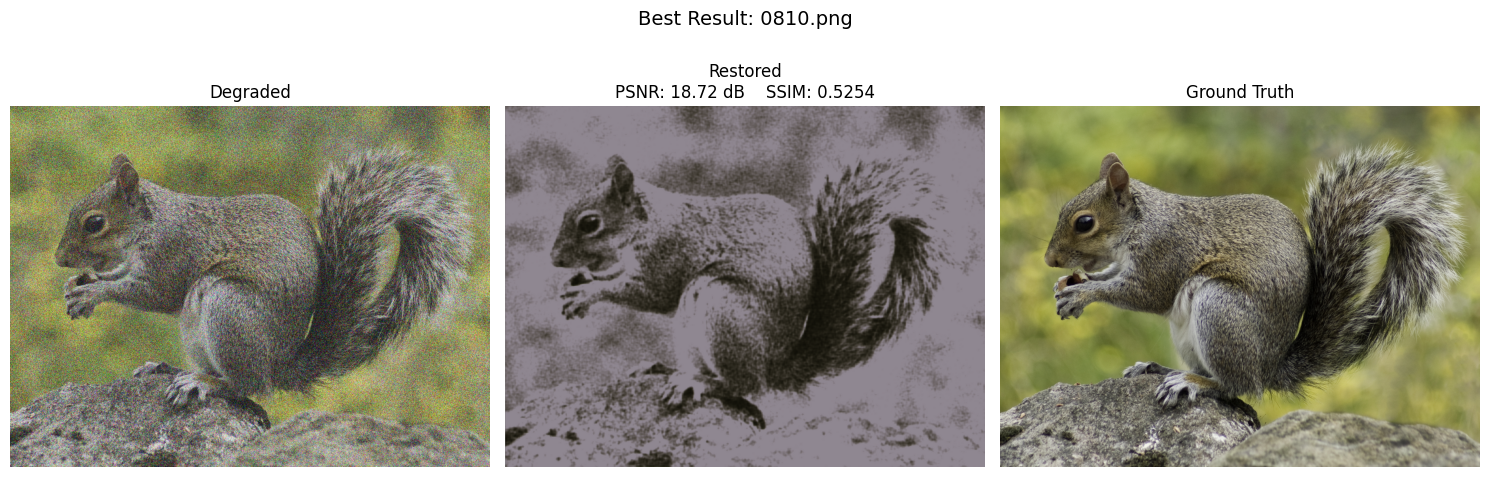


⚠️ Worst result: 0808.png
   PSNR: 13.84 dB, SSIM: 0.5292


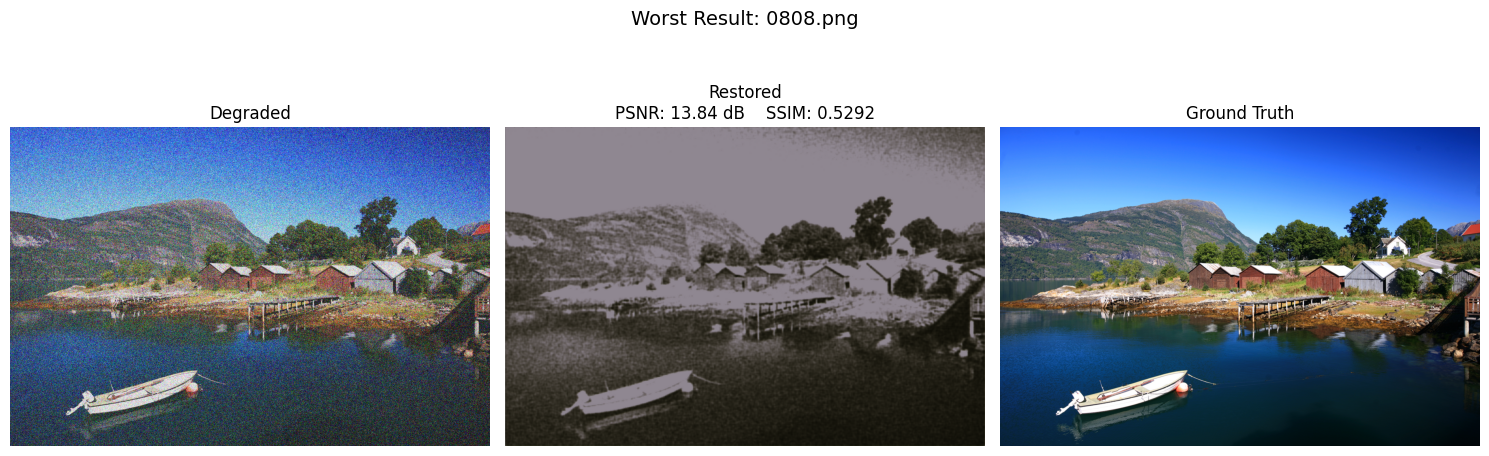

In [ ]:
# Get best and worst images
best_img = max(eval_results["per_image"], key=lambda x: x["psnr"])
worst_img = min(eval_results["per_image"], key=lambda x: x["psnr"])


# Load images for visualization
def load_image_trio(filename):
    degraded_path = Path(config["val_degraded_dir"]) / filename
    clean_path = Path(config["val_clean_dir"]) / filename
    restored_path = exp_dir / "restored_images" / filename

    degraded = cv2.cvtColor(cv2.imread(str(degraded_path)), cv2.COLOR_BGR2RGB)
    clean = cv2.cvtColor(cv2.imread(str(clean_path)), cv2.COLOR_BGR2RGB)
    restored = cv2.cvtColor(cv2.imread(str(restored_path)), cv2.COLOR_BGR2RGB)

    return degraded, restored, clean


# Visualize best result
print(f"\n🏆 Best result: {best_img['filename']}")
print(f"   PSNR: {best_img['psnr']:.2f} dB, SSIM: {best_img['ssim']:.4f}")

deg, res, cln = load_image_trio(best_img["filename"])

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(deg)
axes[0].set_title("Degraded")
axes[0].axis("off")
axes[1].imshow(res)
axes[1].set_title(
    f"Restored\nPSNR: {best_img['psnr']:.2f} dB    SSIM: {best_img['ssim']:.4f}"
)
axes[1].axis("off")
axes[2].imshow(cln)
axes[2].set_title("Ground Truth")
axes[2].axis("off")

plt.suptitle(f"Best Result: {best_img['filename']}", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(samples_dir / "best_full_restoration.png", dpi=150, bbox_inches="tight")
plt.show()

# Visualize worst result
print(f"\n⚠️ Worst result: {worst_img['filename']}")
print(f"   PSNR: {worst_img['psnr']:.2f} dB, SSIM: {worst_img['ssim']:.4f}")

deg, res, cln = load_image_trio(worst_img["filename"])

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(deg)
axes[0].set_title("Degraded")
axes[0].axis("off")
axes[1].imshow(res)
axes[1].set_title(
    f"Restored\nPSNR: {worst_img['psnr']:.2f} dB    SSIM: {worst_img['ssim']:.4f}"
)
axes[1].axis("off")
axes[2].imshow(cln)
axes[2].set_title("Ground Truth")
axes[2].axis("off")

plt.suptitle(f"Worst Result: {worst_img['filename']}", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(samples_dir / "worst_full_restoration.png", dpi=150, bbox_inches="tight")
plt.show()